## Environment Setup

In [1]:
#!pip install openpyxl

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.insert (0, './_functions_/')
from functions_eda import *

## Datasets

In [3]:
df = merge_excel_sheets("./raw_data/02__autos_nach_bundesland_kraftstoff.xlsx")
df.head()

,Land,Kraftstoffart,Kraftfahrzeuge \ninsgesamt,Year
0,Baden-Württemberg,Benzin,5003238,2019
1,Baden-Württemberg,Diesel,2984960,2019
2,Baden-Württemberg,Gas insgesamt,49062,2019
3,Baden-Württemberg,Elektro,19508,2019
4,Baden-Württemberg,Hybrid insgesamt,52055,2019


## Handling missing values

Check for NaNs

In [4]:
df.isnull().sum()

Land                            0
Kraftstoffart                 126
Kraftfahrzeuge \ninsgesamt      0
Year                            0
dtype: int64

The lines that contain no Kraftstoffart are the ones that include totals, therefore we will replace with the value 'Total'

In [5]:
# the lines that contain no Kraftstoffart are the ones that include totals, therefore we will replace with the value 'Total'
df['Kraftstoffart'] = df['Kraftstoffart'].fillna('Total') 
df

,Land,Kraftstoffart,Kraftfahrzeuge \ninsgesamt,Year
0,Baden-Württemberg,Benzin,5003238,2019
1,Baden-Württemberg,Diesel,2984960,2019
2,Baden-Württemberg,Gas insgesamt,49062,2019
3,Baden-Württemberg,Elektro,19508,2019
4,Baden-Württemberg,Hybrid insgesamt,52055,2019
...,...,...,...,...
1003,Deutschland,Elektro (BEV),1810815,2025
1004,Deutschland,Hybrid insgesamt,3573138,2025
1005,Deutschland,darunter Plug-in,968734,2025
1006,Deutschland,Sonstige,18772,2025


In [6]:
df['Land'].value_counts()

Land
Baden-Württemberg                  49
Bayern                             49
Brandenburg                        49
Berlin                             49
Schleswig-Holstein                 49
Thüringen                          49
Hamburg                            49
Bremen                             49
Niedersachsen                      49
Nordrhein-Westfalen                49
Mecklenburg-Vorpommern             49
Hessen                             49
Sachsen                            49
Sachsen-Anhalt                     49
Deutschland                        49
Sonstige                           49
Saarland                           49
Rheinland-Pfalz                    49
Bayern zusammen                     7
Baden-Württemberg zusammen          7
Nordrhein-Westfalen zusammen        7
Niedersachsen zusammen              7
Hessen zusammen                     7
Mecklenburg-Vorpommern zusammen     7
Brandenburg zusammen                7
Berlin zusammen                     7
Bremen 

In [7]:
#remove the text "zusammen" or "insgesamt" from the Land
df['Land'] = df['Land'].str.replace(r'\s+zusammen$', '', regex=True)
df['Land'] = df['Land'].str.replace(r'\s+insgesamt$', '', regex=True)


In [8]:
df['Land'].value_counts()

Land
Baden-Württemberg         56
Bayern                    56
Berlin                    56
Brandenburg               56
Bremen                    56
Hamburg                   56
Hessen                    56
Mecklenburg-Vorpommern    56
Niedersachsen             56
Nordrhein-Westfalen       56
Rheinland-Pfalz           56
Saarland                  56
Sachsen                   56
Sachsen-Anhalt            56
Schleswig-Holstein        56
Thüringen                 56
Sonstige                  56
Deutschland               56
Name: count, dtype: int64

In [9]:
# Remove "Sonstige" from the dataset,since we are interested in the german states
df = df[~(df["Land"] =="Sonstige")]
df

,Land,Kraftstoffart,Kraftfahrzeuge \ninsgesamt,Year
0,Baden-Württemberg,Benzin,5003238,2019
1,Baden-Württemberg,Diesel,2984960,2019
2,Baden-Württemberg,Gas insgesamt,49062,2019
3,Baden-Württemberg,Elektro,19508,2019
4,Baden-Württemberg,Hybrid insgesamt,52055,2019
...,...,...,...,...
1003,Deutschland,Elektro (BEV),1810815,2025
1004,Deutschland,Hybrid insgesamt,3573138,2025
1005,Deutschland,darunter Plug-in,968734,2025
1006,Deutschland,Sonstige,18772,2025


In [10]:
df ['Kraftstoffart'].value_counts()

Kraftstoffart
Benzin                119
Diesel                119
Gas insgesamt         119
Hybrid insgesamt      119
Total                 119
Sonstige              119
Elektro (BEV)          85
darunter Plug-in       85
Elektro                34
  darunter Plug-in     34
Name: count, dtype: int64

In [11]:
df.columns

Index(['Land', 'Kraftstoffart', 'Kraftfahrzeuge \ninsgesamt', 'Year'], dtype='object')

In [12]:
df = df.rename(columns ={'Land':'land', 'Kraftstoffart':'fuel', 'Kraftfahrzeuge \ninsgesamt': 'total_cars', 'Year':'year'})
df

,land,fuel,total_cars,year
0,Baden-Württemberg,Benzin,5003238,2019
1,Baden-Württemberg,Diesel,2984960,2019
2,Baden-Württemberg,Gas insgesamt,49062,2019
3,Baden-Württemberg,Elektro,19508,2019
4,Baden-Württemberg,Hybrid insgesamt,52055,2019
...,...,...,...,...
1003,Deutschland,Elektro (BEV),1810815,2025
1004,Deutschland,Hybrid insgesamt,3573138,2025
1005,Deutschland,darunter Plug-in,968734,2025
1006,Deutschland,Sonstige,18772,2025


In [13]:
# harmonize the types of "fuel"

fuel_type_mapping = {
 'Benzin': 'Benzin', 
 'Diesel': 'Diesel', 
 'Gas insgesamt': 'Gas', 
 'Hybrid insgesamt': 'Hybrid total', 
 'Sonstige': 'Sonstige',
 'Elektro (BEV)': 'Electric', 
 'Elektro': 'Electric', 
 'darunter Plug-in': 'Plug-in Hybrid',
 '  darunter Plug-in': 'Plug-in Hybrid'  
 }

df['fuel'] = df['fuel'].replace(fuel_type_mapping)
df["fuel"].value_counts()


fuel
Benzin            119
Diesel            119
Gas               119
Electric          119
Hybrid total      119
Plug-in Hybrid    119
Sonstige          119
Total             119
Name: count, dtype: int64

In [14]:
df.head()

,land,fuel,total_cars,year
0,Baden-Württemberg,Benzin,5003238,2019
1,Baden-Württemberg,Diesel,2984960,2019
2,Baden-Württemberg,Gas,49062,2019
3,Baden-Württemberg,Electric,19508,2019
4,Baden-Württemberg,Hybrid total,52055,2019


In [15]:
# one df for deutschland
df_germany = df [df ["land"] =="Deutschland"].reset_index()
df_germany

,index,land,fuel,total_cars,year
0,136,Deutschland,Benzin,35732397,2019
1,137,Deutschland,Diesel,20591834,2019
2,138,Deutschland,Gas,507768,2019
3,139,Deutschland,Electric,112119,2019
4,140,Deutschland,Hybrid total,342555,2019
5,141,Deutschland,Plug-in Hybrid,67075,2019
6,142,Deutschland,Sonstige,18528,2019
7,143,Deutschland,Total,57305201,2019
8,280,Deutschland,Benzin,36253555,2020
9,281,Deutschland,Diesel,20683724,2020


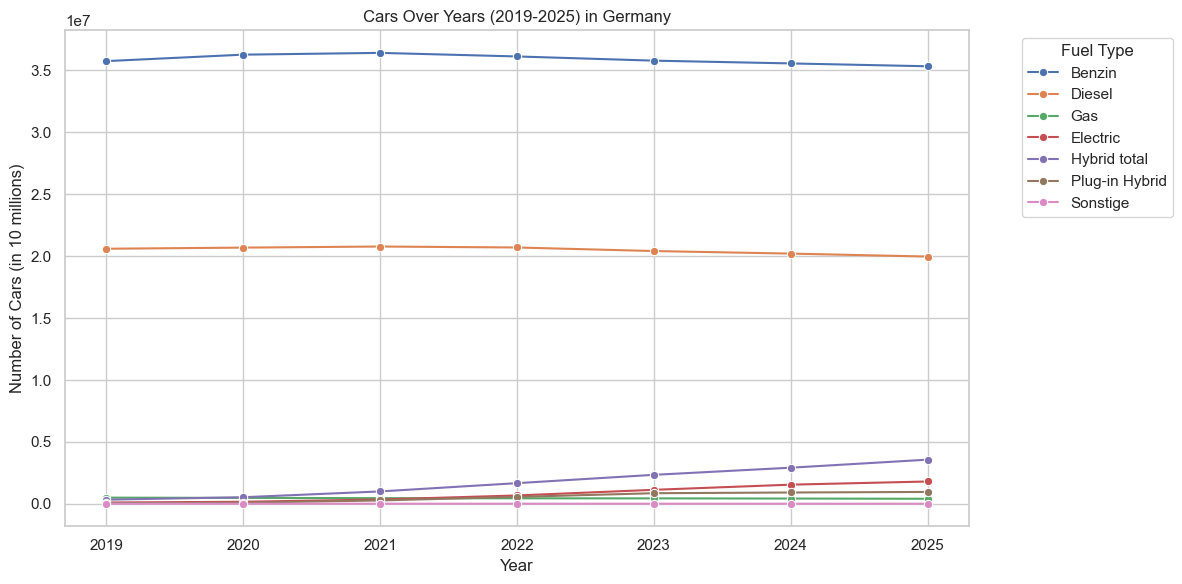

In [16]:
# Set the plot style
sns.set_style("whitegrid")

# excludes total, as it includes all the fuel types
df_germany_filtered = df_germany[df_germany["fuel"] != "Total"]

# Pivot the data to get years on x-axis and fuel types as separate lines
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_germany_filtered, x="year", y="total_cars", hue="fuel", marker="o")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Number of Cars (in 10 millions)")
plt.title("Cars Over Years (2019-2025) in Germany")

# Move legend outside
plt.legend(title="Fuel Type", bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout to fit legend
plt.tight_layout()
plt.show()

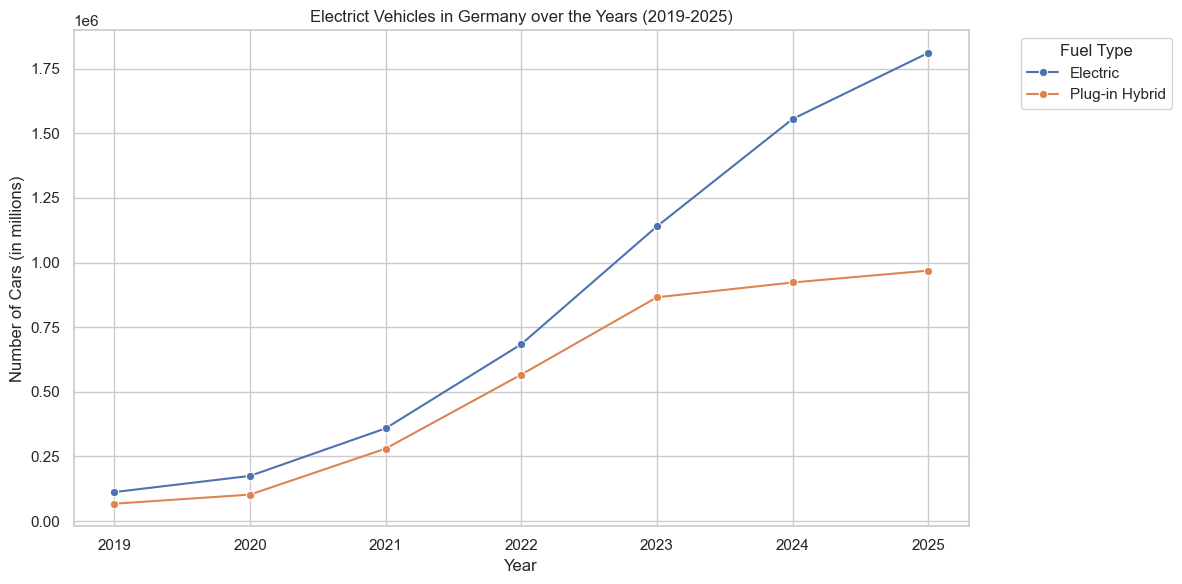

In [17]:
# Set the plot style
sns.set_style("whitegrid")

# here we consider pure electrical and plug-in hybrids as electrical cars
df_electric = df_germany[df_germany["fuel"].isin(["Electric", "Plug-in Hybrid"])]

# Pivot the data to get years on x-axis and fuel types as separate lines
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_electric, x="year", y="total_cars", hue="fuel", marker="o")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Number of Cars (in millions)")
plt.title("Electrict Vehicles in Germany over the Years (2019-2025)")

# Move legend outside
plt.legend(title="Fuel Type", bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout to fit legend
plt.tight_layout()
plt.show()

In [18]:
# Remove "Deutschland" from the dataset, as it contains aggregations
df_states = df[~(df["land"] =="Deutschland")]
df_states

,land,fuel,total_cars,year
0,Baden-Württemberg,Benzin,5003238,2019
1,Baden-Württemberg,Diesel,2984960,2019
2,Baden-Württemberg,Gas,49062,2019
3,Baden-Württemberg,Electric,19508,2019
4,Baden-Württemberg,Hybrid total,52055,2019
...,...,...,...,...
987,Thüringen,Electric,23915,2025
988,Thüringen,Hybrid total,73958,2025
989,Thüringen,Plug-in Hybrid,15529,2025
990,Thüringen,Sonstige,449,2025


In [19]:
df_states.to_csv('./clean_data/cars_based_on_fuel_per_year.csv',  index=False)

Since we are only interested in E-Autos and the rest, we will convert the data again

In [20]:
fuel_type_mapping2 = {
 'Benzin': 'Others', 
 'Diesel': 'Others', 
 'Gas': 'Others',  
 'Sonstige': 'Others',
 'Hybrid': 'Others',  
 'Electric': 'Electric',
 'Hybrid E': 'Plug-in Hybrid'  
 }

df_states['fuel'] = df_states['fuel'].replace(fuel_type_mapping2)
df_states["fuel"].value_counts()

fuel
Others            448
Electric          112
Hybrid total      112
Plug-in Hybrid    112
Total             112
Name: count, dtype: int64

In [21]:
df_states.to_csv('./clean_data/cars_based_on_fuel_per_year_filtered.csv',  index=False)

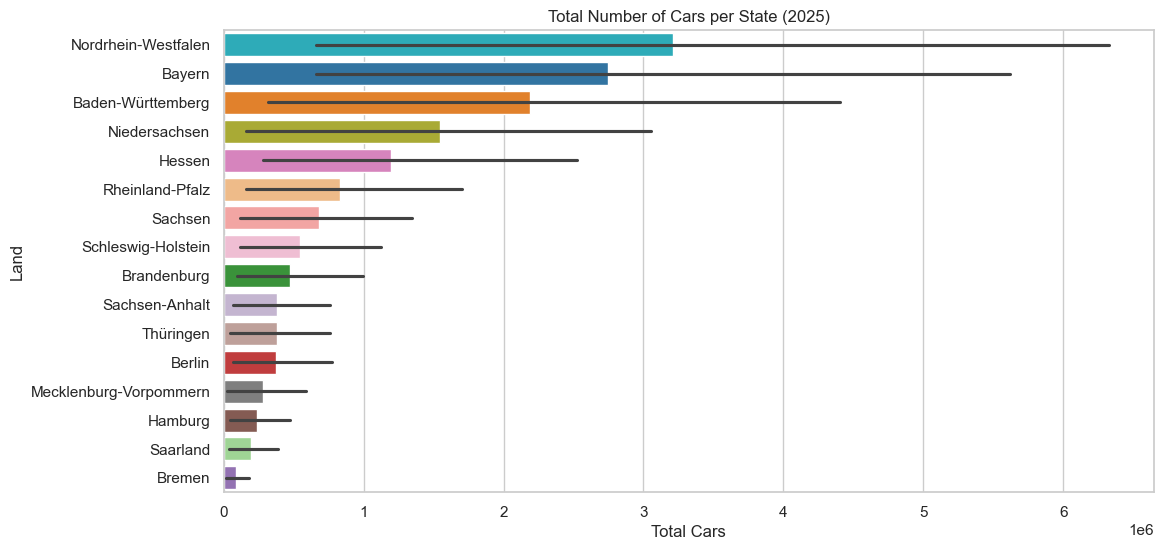

In [22]:
# Filter data for 2025
df_2025 = df_states[df_states["year"] == 2025]

# Sort by total number of cars for better visualization
df_2025 = df_2025.sort_values(by="total_cars", ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_2025, x="total_cars", y="land", palette=german_states_colors)

# Labels and title
plt.xlabel("Total Cars")
plt.ylabel("Land")
plt.title("Total Number of Cars per State (2025)")

# Show the plot
plt.show()


In [23]:
df_states['fuel'].value_counts()


fuel
Others            448
Electric          112
Hybrid total      112
Plug-in Hybrid    112
Total             112
Name: count, dtype: int64

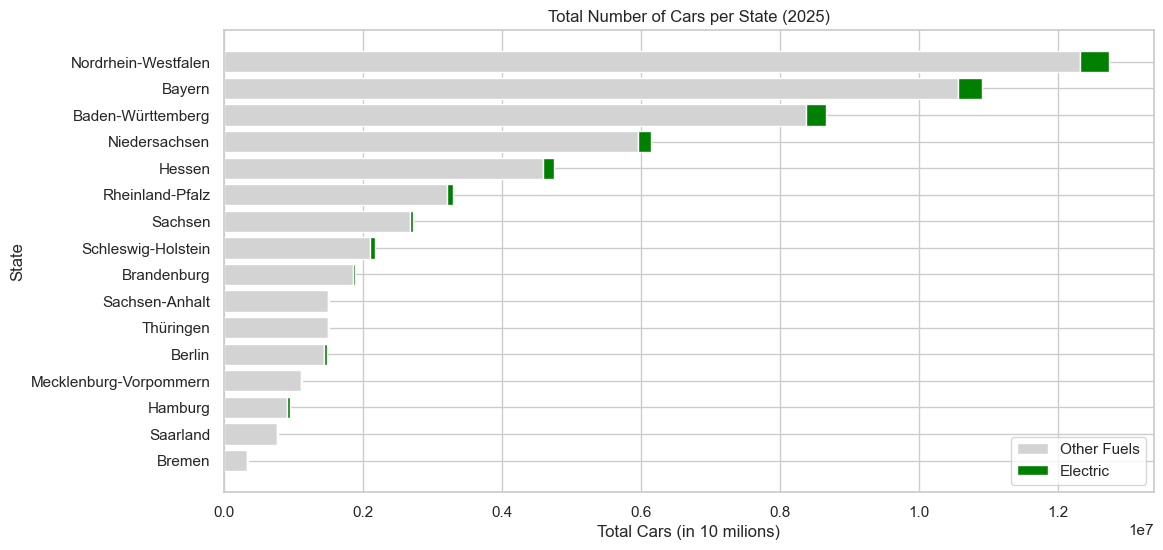

In [24]:
# Filter data for 2025
df_2025 = df_states[df_states["year"] == 2025]

# Pivot table to get total cars by fuel type for each Land
df_pivot = df_2025.pivot_table(index="land", columns="fuel", values="total_cars", aggfunc="sum")

# Sort by total number of cars for better visualization
df_pivot = df_pivot.sort_values(by="Total", ascending=True)

# Handle missing values (if some states don't have electric cars)
df_pivot = df_pivot.fillna(0)

# Compute non-electric cars
df_pivot["Non_Electric"] = df_pivot["Total"] - df_pivot["Electric"]

# Plot stacked bar chart
plt.figure(figsize=(12, 6))

plt.barh(df_pivot.index, df_pivot["Non_Electric"], color="lightgray", label="Other Fuels")
plt.barh(df_pivot.index, df_pivot["Electric"], left=df_pivot["Non_Electric"], color="green", label="Electric")

# Labels and title
plt.xlabel("Total Cars (in 10 milions)")
plt.ylabel("State")
plt.title("Total Number of Cars per State (2025)")
plt.legend()

# Show the plot
plt.show()



### Creates a new dataframe

Creates a Dataframe with the information about year 2023

Save the total of electrical cars in year 2023, since this is the year we have the counts for the population

In [51]:
autos_2023 = df_states [df_states["year"] == 2023]
autos_2023.rename(columns = {"land":"state"}, inplace=True)

# we consider electric and hybrid as electrical, since they all use the charging stations
electric_types = ["Electric", "Plug-in Hybrid"]

# filter the electrical vehicles
eautos_2023 = autos_2023[autos_2023["fuel"].isin(electric_types)]
# summs the electrical vehicles
e_autos_per_state_2023 = eautos_2023.groupby("state").agg(
    number_of_electric_cars=("total_cars", "sum")     
).reset_index()

e_autos_per_state_2023



,state,number_of_electric_cars
0,Baden-Württemberg,320946
1,Bayern,363975
2,Berlin,58496
3,Brandenburg,39206
4,Bremen,11033
5,Hamburg,47648
6,Hessen,194759
7,Mecklenburg-Vorpommern,17821
8,Niedersachsen,188133
9,Nordrhein-Westfalen,469380


In [58]:
# filter the total of cars
total_cars_2023 = autos_2023 [autos_2023['fuel'] == 'Total']
total_cars_2023.drop(columns=['fuel', 'year'], inplace=True)                    
                     

Merges the total of electrical cars with the total of cars, and adds a column total of non-electric

In [59]:
autos_state_2023 = e_autos_per_state_2023.merge(total_cars_2023, on = "state", how="left")
autos_state_2023


,state,number_of_electric_cars,total_cars
0,Baden-Württemberg,320946,8502375
1,Bayern,363975,10701508
2,Berlin,58496,1497935
3,Brandenburg,39206,1855667
4,Bremen,11033,347022
5,Hamburg,47648,957483
6,Hessen,194759,4669933
7,Mecklenburg-Vorpommern,17821,1107639
8,Niedersachsen,188133,6049627
9,Nordrhein-Westfalen,469380,12509877


In [62]:
autos_state_2023['number_non_electric_cars'] = autos_state_2023['total_cars'] - autos_state_2023['number_of_electric_cars']
autos_state_2023.rename (columns = {'total_cars':'number_cars'}, inplace = True)
autos_state_2023


,state,number_of_electric_cars,number_cars,number_non_electric,number_non_electric_cars
0,Baden-Württemberg,320946,8502375,8181429,8181429
1,Bayern,363975,10701508,10337533,10337533
2,Berlin,58496,1497935,1439439,1439439
3,Brandenburg,39206,1855667,1816461,1816461
4,Bremen,11033,347022,335989,335989
5,Hamburg,47648,957483,909835,909835
6,Hessen,194759,4669933,4475174,4475174
7,Mecklenburg-Vorpommern,17821,1107639,1089818,1089818
8,Niedersachsen,188133,6049627,5861494,5861494
9,Nordrhein-Westfalen,469380,12509877,12040497,12040497


In [64]:
autos_state_2023.to_csv("./clean_data/autos_state_2023.csv", index = False)

In [28]:
def plot_stacked_bar_for_state(df, land, colors):
    """
    Creates a stacked bar plot showing the number of electric vs. other fuel cars over different years for a given Land.

    Parameters:
        df (pd.DataFrame): The dataset containing columns 'Land', 'Fuel', 'Total cars', and 'Year'.
        land (str): The name of the Land (state) to visualize.
        german_states_colors (dict): A dictionary mapping German states to colors.
    """

    # Filter data for the selected Land
    df_land = df[df["land"] == land]

    # Pivot table to get fuel types as columns and years as index
    df_pivot = df_land.pivot_table(index="year", columns="fuel", values="total_cars", aggfunc="sum")

    # Handle missing values (if some years don't have electric cars)
    df_pivot = df_pivot.fillna(0)

    # Compute non-electric cars
    df_pivot["Non_Electric"] = df_pivot["Total"] - df_pivot["Electric"]

    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Set bar width
    bar_width = 0.5  # Adjusted from default 0.8 to make bars slimmer
    
    # Plot "Non_Electric" in the state's assigned color
    plt.bar(df_pivot.index, df_pivot["Non_Electric"], color=german_states_colors.get(land, "black"), label="Other Fuels", width=bar_width)

    # Plot "Electric" on top in gray
    plt.bar(df_pivot.index, df_pivot["Electric"], bottom=df_pivot["Non_Electric"], color="gray", label="Electric", width=bar_width)


    # Add text labels for electric percentage
    for year in df_pivot.index:
        total = df_pivot.loc[year, "Total"]
        electric = df_pivot.loc[year, "Electric"]
        percent = (electric / total) * 100 if total > 0 else 0

        plt.text(year, total * 1.02, f"{percent:.1f}%", ha='center', fontsize=10, color="black")

    # Labels and title
    plt.xlabel("Year")
    plt.ylabel("Total Cars")
    plt.title(f"Electric vs Other Cars in {land} Over the Years")
    plt.xticks(df_pivot.index)  # Ensure all years are shown
    plt.legend()

    # Show the plot
    plt.show()


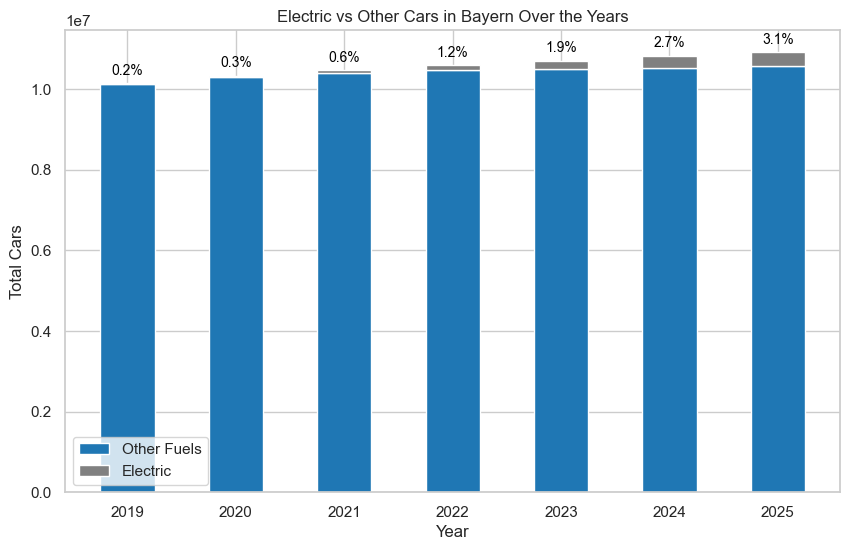

In [29]:
plot_stacked_bar_for_state(df = df_states, land ='Bayern', colors= german_states_colors)

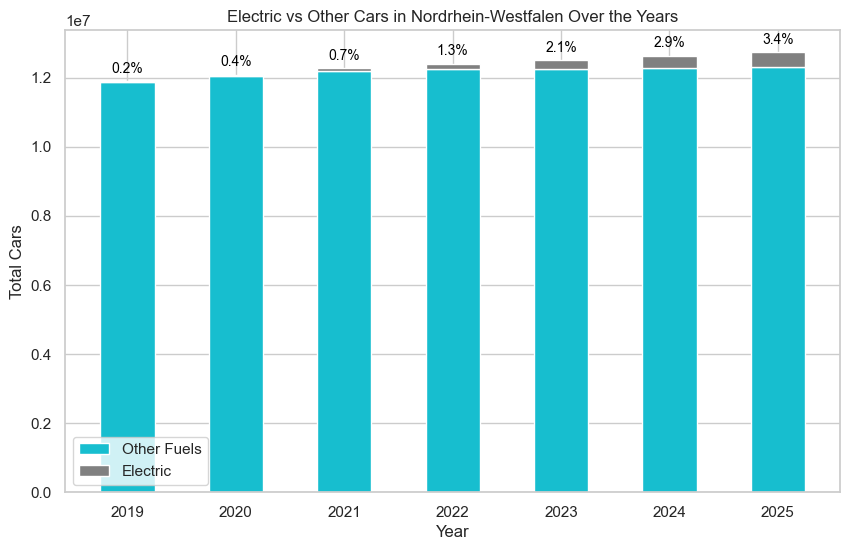

In [30]:
plot_stacked_bar_for_state(df = df_states, land ='Nordrhein-Westfalen', colors= german_states_colors)

In [31]:
import matplotlib.pyplot as plt

def plot_line_chart_for_state(df, land, colors):
    """
    Creates a line chart showing the number of electric vs. other fuel cars over different years for a given Land.

    Parameters:
        df (pd.DataFrame): The dataset containing columns 'Land', 'Fuel', 'Total cars', and 'Year'.
        land (str): The name of the Land (state) to visualize.
        colors (dict): A dictionary mapping fuel types to colors for the line chart.
    """

    # Filter data for the selected Land
    df_land = df[df["land"] == land]

    # Pivot table to get fuel types as columns and years as index
    df_pivot = df_land.pivot_table(index="year", columns="fuel", values="total_cars", aggfunc="sum")

    # Handle missing values (if some years don't have electric cars)
    df_pivot = df_pivot.fillna(0)

    # Compute non-electric cars
    if "Electric" in df_pivot.columns:
        df_pivot["Non_Electric"] = df_pivot["Total"] - df_pivot["Electric"]
    else:
        df_pivot["Non_Electric"] = df_pivot["Total"]  # If no electric data exists, assume all cars are non-electric

    # Create figure
    plt.figure(figsize=(10, 6))

    # Plot line chart for "Non_Electric" cars
    plt.plot(df_pivot.index, df_pivot["Non_Electric"], color=german_states_colors.get(land, "black"), label="Other Fuels", marker='o')

    # Plot line chart for "Electric" cars
    plt.plot(df_pivot.index, df_pivot["Electric"], color="gray", label="Electric", marker='o')

    # Add text labels for electric percentage on each point
    for year in df_pivot.index:
        total = df_pivot.loc[year, "Total"]
        electric = df_pivot.loc[year, "Electric"]
        percent = (electric / total) * 100 if total > 0 else 0
        plt.text(year, electric + 0.05 * total, f"{percent:.1f}%", ha='center', fontsize=10, color="black")

    # Labels and title
    plt.xlabel("Year")
    plt.ylabel("Total Cars")
    plt.title(f"Electric vs Other Cars in {land} Over the Years")
    plt.xticks(df_pivot.index)  # Ensure all years are shown
    plt.legend()

    # Show the plot
    plt.show()


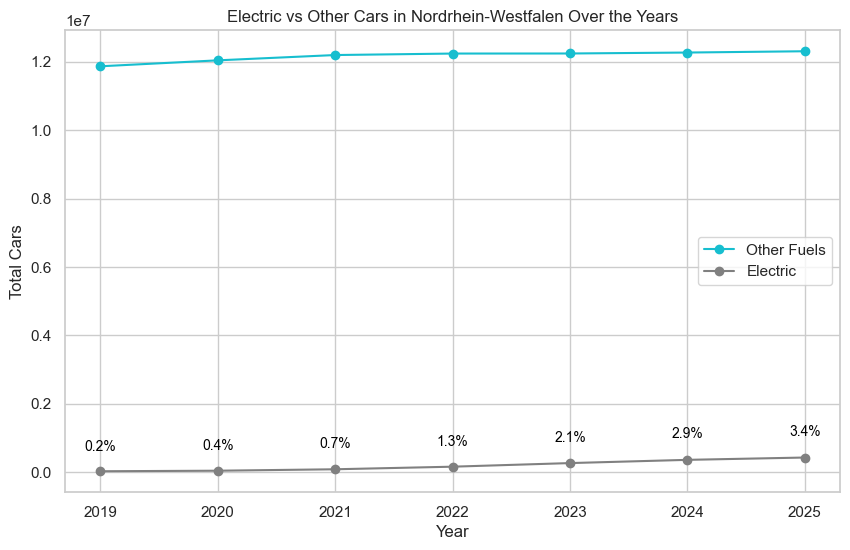

In [32]:
plot_line_chart_for_state(df = df_states, land ='Nordrhein-Westfalen', colors= german_states_colors)

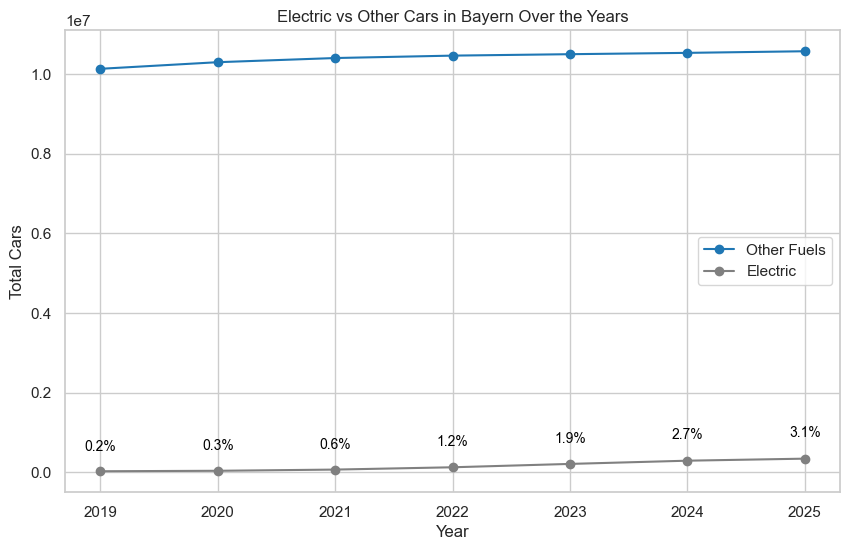

In [33]:
plot_line_chart_for_state(df = df_states, land ='Bayern', colors= german_states_colors)

In [34]:
# Filter for electric and plug-in hybrid cars
electric_types = ["Electric", "Plug-in Hybrid"]
df_total_electric = df_states[df_states["fuel"].isin(electric_types)]

# Group by land and year to get total electric cars
electric_summary = df_total_electric.groupby(["land", "year"])["total_cars"].sum().reset_index()
electric_summary.rename(columns={"total_cars": "total_electric"}, inplace=True)



In [35]:
# Check for rows where the fuel column is "Total"
df_total_flag = df_states[df_states["fuel"].str.lower() == "total"]

# Keep only these rows as the actual total per state/year
total_cars_summary_corrected = df_total_flag[["land", "year", "total_cars"]].copy()
total_cars_summary_corrected.rename(columns={"total_cars": "total_all"}, inplace=True)

# Reuse the already computed total electric (electric + plug-in hybrid)
# electric_summary is already grouped by land and year
# Merge with the corrected total cars
merged_df_corrected = pd.merge(total_cars_summary_corrected, electric_summary, on=["land", "year"], how="left")
merged_df_corrected["total_electric"] = merged_df_corrected["total_electric"].fillna(0).astype(int)
merged_df_corrected["total_non_electric"] = merged_df_corrected["total_all"] - merged_df_corrected["total_electric"]

# Select and reorder columns
final_df_corrected = merged_df_corrected[["land", "total_electric", "total_non_electric", "year"]]

final_df_corrected.head()


,land,total_electric,total_non_electric,year
0,Baden-Württemberg,32226,8078916,2019
1,Bayern,38640,10111968,2019
2,Berlin,5537,1428604,2019
3,Brandenburg,3358,1756562,2019
4,Bremen,931,336240,2019


In [36]:
final_df_corrected.shape

(112, 4)

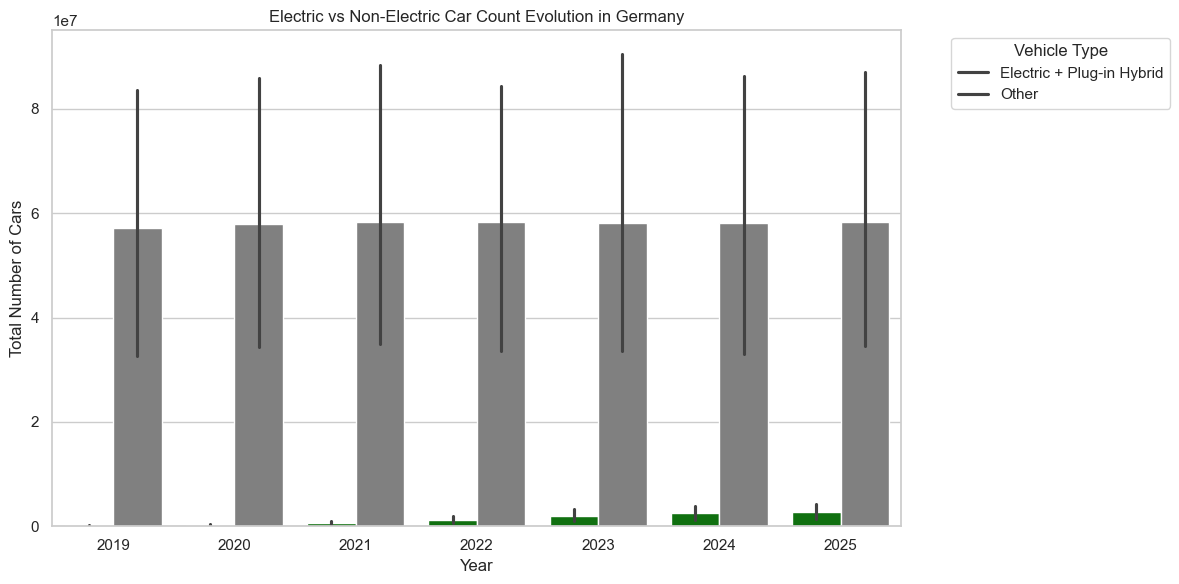

In [37]:
# Set plot style
sns.set(style="whitegrid")

# Melt the DataFrame to long format for plotting
plot_df = final_df_corrected.melt(id_vars=["land", "year"],
                                  value_vars=["total_electric", "total_non_electric"],
                                  var_name="Type",
                                  value_name="Count")

# Create a color palette
palette = {"total_electric": "green", "total_non_electric": "gray"}

# Plot: Evolution per year (aggregated across all states)
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x="year", y="Count", hue="Type", estimator=sum, palette=palette)

plt.title("Electric vs Non-Electric Car Count Evolution in Germany")
plt.ylabel("Total Number of Cars")
plt.xlabel("Year")
plt.legend(title="Vehicle Type", labels=["Electric + Plug-in Hybrid", "Other"], bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()